In [7]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
from keras import regularizers
from math import sqrt
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
from numpy import concatenate
import random
import time


In [8]:

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime(x, "'[%H:%M:%S %d/%m/%Y]'")

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    totalRMSE=list()
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        totalRMSE.append(rmse)
        print('t+%d RMSE: %f' % ((i+1), rmse))
    print("Avrage RMSE",np.mean(totalRMSE))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

# load dataset
series = read_csv('samples(3).csv', header=1,parse_dates=[0],index_col=0, squeeze=True,date_parser=parser)	

# configure


In [9]:
n_lag = 6
n_seq = 5
n_test = 420
n_epochs = 5
n_batch = 1
n_neurons = 50
# extract raw values
raw_values = series.values
# transform data to be stationary
diff_series = difference(raw_values, 1)
diff_values = diff_series.values
diff_values = diff_values.reshape(len(diff_values), 1)
# rescale values to -1, 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(diff_values)
scaled_values = scaled_values.reshape(len(scaled_values), 1)
# transform into supervised learning problem X, y
supervised = series_to_supervised(scaled_values, n_lag, n_seq)
supervised_values = supervised.values
# split into train and test sets
train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
X_train, y_train = train[:, 0:n_lag], train[:, n_lag:]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])



In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch


def build_model(hp):
    num_units_min  =  10
    num_units_max  =  200
    num_units_step =  10

    dropout_min  =  .2
    dropout_max  =  0.5
    dropout_step =  0.1
    
    model = keras.Sequential()
    model.add(layers.GRU(units=hp.Int('unit1',  min_value=num_units_min,
                                                 max_value=num_units_max,
                                                 step=num_units_step),
                                                 activation='relu',
                                                 input_shape=(X_train.shape[1], X_train.shape[2]), 
                                                 kernel_initializer='normal', 
                                                 kernel_regularizer=keras.regularizers.l2(hp.Choice('reg_rate1',values=[0.01, 0.05, 0.1])),
                        
                                                 return_sequences = True))
    model.add(layers.Dropout(hp.Float('dropout_1',min_value=dropout_min,
                                      max_value=dropout_max,
                                      step=dropout_step) ) )

    '''for i in range(hp.Int('num_layers', 1, 1)):
        model.add(layers.LSTM(units=hp.Int('unitfor_'+ str(i),
                                           min_value=num_units_min,
                                           max_value=num_units_max,
                                         step=num_units_step),
                                        activation='relu', 
                                         kernel_initializer='normal', 
                                          return_sequences = True))
        model.add(layers.Dropout(hp.Float('dropoutfor_'+ str(i), 
                                    min_value=dropout_min,
                                    max_value=dropout_max,
                                      step=dropout_step)))'''
    model.add(layers.GRU(units=hp.Int('unit4',  min_value=num_units_min,
                                                 max_value=num_units_max,
                                                 step=num_units_step),
                                                 activation='relu',
                                                 
                                                 kernel_initializer='normal', 
                                                 kernel_regularizer=keras.regularizers.l2(hp.Choice('reg_rate2',values=[0.01, 0.05, 0.1])),
                          
                                                 return_sequences = False))
    model.add(layers.Dropout(hp.Float('dropout_4',min_value=dropout_min,
                                      max_value=dropout_max,
                                     step=dropout_step) ) )
    ''' model.add(layers.Flatten())
    for i in range(hp.Int('num_layers', 1, 2)):
        model.add(layers.Dense(units=hp.Int('unitsdense_'+ str(i),
                                            min_value=20,
                                            max_value=300,
                                            step=10),
                                            activation='relu',
                              kernel_regularizer=keras.regularizers.l2(hp.Choice('reg_rate1',values=[0.01, 0.05, 0.1]))))   
        model.add(layers.Dropout(hp.Float('dropoutdense_'+ str(i), 
                                      min_value=dropout_min,
                                      max_value=dropout_max,
                                      step=dropout_step))) '''
    model.add(layers.Dense(n_seq))
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_squared_error', 'mean_absolute_error'])
    return model


In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

tuner = RandomSearch(
    build_model,
    objective='mean_squared_error',
    max_trials=2,
  
    project_name='GRUtwolayer')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:

early_stopping = EarlyStopping(monitor='mean_squared_error', patience=10, verbose=1)
callback_list = [ early_stopping ]

# split training data into stratified train/dev sets

tuner.search(X_train, y_train,
             epochs=10,
             batch_size=1, 
             callbacks=callback_list)
model = tuner.get_best_models(num_models=1)[0]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1275 samples
Epoch 1/10


 152/1275 [==>...........................] - ETA: 1:10:44 - loss: 1.4704 - mean_squared_error: 0.0187 - mean_absolute_error: 0.108 - ETA: 17:58 - loss: 1.4036 - mean_squared_error: 0.0190 - mean_absolute_error: 0.1115  - ETA: 14:34 - loss: 1.3929 - mean_squared_error: 0.0299 - mean_absolute_error: 0.130 - ETA: 10:37 - loss: 1.3461 - mean_squared_error: 0.0252 - mean_absolute_error: 0.119 - ETA: 8:25 - loss: 1.3113 - mean_squared_error: 0.0309 - mean_absolute_error: 0.135 - ETA: 7:40 - loss: 1.2940 - mean_squared_error: 0.0332 - mean_absolute_error: 0.14 - ETA: 6:29 - loss: 1.2525 - mean_squared_error: 0.0300 - mean_absolute_error: 0.13 - ETA: 6:05 - loss: 1.2335 - mean_squared_error: 0.0297 - mean_absolute_error: 0.13 - ETA: 5:46 - loss: 1.2138 - mean_squared_error: 0.0282 - mean_absolute_error: 0.13 - ETA: 5:27 - loss: 1.1943 - mean_squared_error: 0.0266 - mean_absolute_error: 0.12 - ETA: 5:17 - loss: 1.1843 - mean_squared_error: 0.0341 - mean_absolute_error: 0.14 - ETA: 5:02 - loss: 

 715/1275 [===============>..............] - ETA: 31s - loss: 0.1349 - mean_squared_error: 0.0321 - mean_absolute_error: 0.119 - ETA: 31s - loss: 0.1342 - mean_squared_error: 0.0321 - mean_absolute_error: 0.119 - ETA: 30s - loss: 0.1335 - mean_squared_error: 0.0321 - mean_absolute_error: 0.119 - ETA: 31s - loss: 0.1332 - mean_squared_error: 0.0320 - mean_absolute_error: 0.119 - ETA: 31s - loss: 0.1329 - mean_squared_error: 0.0320 - mean_absolute_error: 0.119 - ETA: 30s - loss: 0.1326 - mean_squared_error: 0.0321 - mean_absolute_error: 0.119 - ETA: 30s - loss: 0.1319 - mean_squared_error: 0.0321 - mean_absolute_error: 0.119 - ETA: 30s - loss: 0.1310 - mean_squared_error: 0.0321 - mean_absolute_error: 0.119 - ETA: 29s - loss: 0.1297 - mean_squared_error: 0.0321 - mean_absolute_error: 0.119 - ETA: 29s - loss: 0.1285 - mean_squared_error: 0.0320 - mean_absolute_error: 0.119 - ETA: 29s - loss: 0.1279 - mean_squared_error: 0.0322 - mean_absolute_error: 0.119 - ETA: 28s - loss: 0.1264 - mean_

 939/1275 [=====================>........] - ETA: 16s - loss: 0.0951 - mean_squared_error: 0.0333 - mean_absolute_error: 0.120 - ETA: 16s - loss: 0.0946 - mean_squared_error: 0.0332 - mean_absolute_error: 0.120 - ETA: 16s - loss: 0.0942 - mean_squared_error: 0.0333 - mean_absolute_error: 0.120 - ETA: 16s - loss: 0.0938 - mean_squared_error: 0.0332 - mean_absolute_error: 0.120 - ETA: 15s - loss: 0.0936 - mean_squared_error: 0.0334 - mean_absolute_error: 0.120 - ETA: 15s - loss: 0.0937 - mean_squared_error: 0.0339 - mean_absolute_error: 0.121 - ETA: 15s - loss: 0.0932 - mean_squared_error: 0.0337 - mean_absolute_error: 0.120 - ETA: 15s - loss: 0.0931 - mean_squared_error: 0.0338 - mean_absolute_error: 0.121 - ETA: 15s - loss: 0.0930 - mean_squared_error: 0.0337 - mean_absolute_error: 0.120 - ETA: 15s - loss: 0.0928 - mean_squared_error: 0.0337 - mean_absolute_error: 0.120 - ETA: 15s - loss: 0.0927 - mean_squared_error: 0.0337 - mean_absolute_error: 0.120 - ETA: 15s - loss: 0.0925 - mean_

1144/1275 [=========================>....] - ETA: 9s - loss: 0.0833 - mean_squared_error: 0.0361 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0832 - mean_squared_error: 0.0361 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0830 - mean_squared_error: 0.0361 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0829 - mean_squared_error: 0.0363 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0829 - mean_squared_error: 0.0362 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0827 - mean_squared_error: 0.0363 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0826 - mean_squared_error: 0.0362 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0825 - mean_squared_error: 0.0363 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0825 - mean_squared_error: 0.0362 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0824 - mean_squared_error: 0.0362 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0825 - mean_squared_error: 0.0364 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0825 - mean_squared_error: 0.0364 -

1275/1275 [==============================] - ETA: 3s - loss: 0.0742 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0741 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0741 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0740 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0739 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0738 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0737 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0735 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0733 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0733 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0732 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0731 - mean_squared_error: 0.0350 -

Epoch 2/10


 203/1275 [===>..........................] - ETA: 49s - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.121 - ETA: 1:06 - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.10 - ETA: 43s - loss: 0.0476 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1523 - ETA: 46s - loss: 0.0411 - mean_squared_error: 0.0411 - mean_absolute_error: 0.141 - ETA: 43s - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_error: 0.134 - ETA: 40s - loss: 0.0558 - mean_squared_error: 0.0558 - mean_absolute_error: 0.150 - ETA: 39s - loss: 0.0526 - mean_squared_error: 0.0526 - mean_absolute_error: 0.152 - ETA: 39s - loss: 0.0492 - mean_squared_error: 0.0492 - mean_absolute_error: 0.151 - ETA: 32s - loss: 0.0439 - mean_squared_error: 0.0439 - mean_absolute_error: 0.144 - ETA: 33s - loss: 0.0422 - mean_squared_error: 0.0422 - mean_absolute_error: 0.140 - ETA: 36s - loss: 0.0464 - mean_squared_error: 0.0464 - mean_absolute_error: 0.149 - ETA: 38s - loss: 0.0439 - mean

 619/1275 [=============>................] - ETA: 27s - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.120 - ETA: 27s - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.121 - ETA: 27s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.120 - ETA: 27s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.120 - ETA: 27s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.120 - ETA: 26s - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.120 - ETA: 26s - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.120 - ETA: 26s - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.120 - ETA: 26s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.120 - ETA: 26s - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.120 - ETA: 26s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.120 - ETA: 26s - loss: 0.0339 - mean_

 874/1275 [===================>..........] - ETA: 19s - loss: 0.0335 - mean_squared_error: 0.0334 - mean_absolute_error: 0.120 - ETA: 19s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.120 - ETA: 19s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.120 - ETA: 19s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.120 - ETA: 19s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.120 - ETA: 19s - loss: 0.0331 - mean_squared_error: 0.0331 - mean_absolute_error: 0.119 - ETA: 18s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.120 - ETA: 18s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.120 - ETA: 18s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.119 - ETA: 18s - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.120 - ETA: 18s - loss: 0.0336 - mean_squared_error: 0.0335 - mean_absolute_error: 0.120 - ETA: 18s - loss: 0.0334 - mean_

1009/1275 [======================>.......] - ETA: 11s - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.120 - ETA: 11s - loss: 0.0339 - mean_squared_error: 0.0338 - mean_absolute_error: 0.120 - ETA: 10s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.120 - ETA: 10s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.120 - ETA: 10s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.120 - ETA: 10s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.120 - ETA: 10s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.120 - ETA: 10s - loss: 0.0340 - mean_squared_error: 0.0339 - mean_absolute_error: 0.120 - ETA: 10s - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.120 - ETA: 10s - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.120 - ETA: 10s - loss: 0.0339 - mean_squared_error: 0.0338 - mean_absolute_error: 0.120 - ETA: 10s - loss: 0.0338 - mean_

1140/1275 [=========================>....] - ETA: 8s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0346 - mean_squared_error: 0.0345 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0346 - mean_squared_error: 0.0345 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0346 - mean_squared_error: 0.0345 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0347 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0347 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0348 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0348 - mean_squared_error: 0.0347 -

1275/1275 [==============================] - ETA: 4s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.0354 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0353 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0351 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0350 - mean_squared_error: 0.0350 -

 215/1275 [====>.........................] - ETA: 21s - loss: 7.5847e-04 - mean_squared_error: 7.4805e-04 - mean_absolute_error: 0.021 - ETA: 28s - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0878        - ETA: 22s - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.080 - ETA: 17s - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.078 - ETA: 16s - loss: 0.0143 - mean_squared_error: 0.0142 - mean_absolute_error: 0.087 - ETA: 15s - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.088 - ETA: 14s - loss: 0.0149 - mean_squared_error: 0.0148 - mean_absolute_error: 0.088 - ETA: 14s - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.093 - ETA: 14s - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.093 - ETA: 14s - loss: 0.0244 - mean_squared_error: 0.0244 - mean_absolute_error: 0.102 - ETA: 15s - loss: 0.0240 - mean_squared_error: 0.0240 - mean_absolute_error: 0.101 - ETA: 20s - loss

 740/1275 [================>.............] - ETA: 19s - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.120 - ETA: 19s - loss: 0.0334 - mean_squared_error: 0.0333 - mean_absolute_error: 0.120 - ETA: 19s - loss: 0.0337 - mean_squared_error: 0.0336 - mean_absolute_error: 0.120 - ETA: 18s - loss: 0.0337 - mean_squared_error: 0.0336 - mean_absolute_error: 0.120 - ETA: 18s - loss: 0.0336 - mean_squared_error: 0.0335 - mean_absolute_error: 0.120 - ETA: 18s - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.120 - ETA: 18s - loss: 0.0334 - mean_squared_error: 0.0333 - mean_absolute_error: 0.120 - ETA: 18s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.120 - ETA: 18s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.120 - ETA: 18s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.120 - ETA: 17s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.120 - ETA: 17s - loss: 0.0329 - mean_

 983/1275 [======================>.......] - ETA: 13s - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.118 - ETA: 13s - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.118 - ETA: 13s - loss: 0.0329 - mean_squared_error: 0.0328 - mean_absolute_error: 0.118 - ETA: 13s - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.118 - ETA: 13s - loss: 0.0330 - mean_squared_error: 0.0329 - mean_absolute_error: 0.118 - ETA: 13s - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.118 - ETA: 13s - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.118 - ETA: 13s - loss: 0.0328 - mean_squared_error: 0.0328 - mean_absolute_error: 0.118 - ETA: 13s - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.117 - ETA: 13s - loss: 0.0327 - mean_squared_error: 0.0326 - mean_absolute_error: 0.117 - ETA: 13s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.118 - ETA: 12s - loss: 0.0333 - mean_

1233/1275 [============================>.] - ETA: 7s - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0344 - mean_squared_error: 0.0343 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0340 - mean_squared_error: 0.0340 -

1275/1275 [==============================] - ETA: 1s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0350 - mean_squared_error: 0.0349 -

 190/1275 [===>..........................] - ETA: 32s - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.093 - ETA: 32s - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.062 - ETA: 50s - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.068 - ETA: 55s - loss: 0.0293 - mean_squared_error: 0.0293 - mean_absolute_error: 0.101 - ETA: 48s - loss: 0.0380 - mean_squared_error: 0.0380 - mean_absolute_error: 0.129 - ETA: 40s - loss: 0.0300 - mean_squared_error: 0.0300 - mean_absolute_error: 0.115 - ETA: 39s - loss: 0.0331 - mean_squared_error: 0.0331 - mean_absolute_error: 0.126 - ETA: 35s - loss: 0.0288 - mean_squared_error: 0.0288 - mean_absolute_error: 0.118 - ETA: 36s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.124 - ETA: 35s - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.120 - ETA: 33s - loss: 0.0285 - mean_squared_error: 0.0285 - mean_absolute_error: 0.110 - ETA: 31s - loss: 0.0270 - mean_

 784/1275 [=================>............] - ETA: 18s - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.116 - ETA: 18s - loss: 0.0323 - mean_squared_error: 0.0322 - mean_absolute_error: 0.116 - ETA: 18s - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.116 - ETA: 18s - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.116 - ETA: 18s - loss: 0.0321 - mean_squared_error: 0.0320 - mean_absolute_error: 0.116 - ETA: 18s - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.115 - ETA: 18s - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.115 - ETA: 17s - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.115 - ETA: 17s - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.115 - ETA: 17s - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.115 - ETA: 17s - loss: 0.0316 - mean_squared_error: 0.0316 - mean_absolute_error: 0.115 - ETA: 17s - loss: 0.0315 - mean_

 987/1275 [======================>.......] - ETA: 11s - loss: 0.0331 - mean_squared_error: 0.0331 - mean_absolute_error: 0.118 - ETA: 11s - loss: 0.0331 - mean_squared_error: 0.0331 - mean_absolute_error: 0.118 - ETA: 11s - loss: 0.0331 - mean_squared_error: 0.0331 - mean_absolute_error: 0.118 - ETA: 11s - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.118 - ETA: 11s - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.118 - ETA: 11s - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.118 - ETA: 10s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.118 - ETA: 10s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.118 - ETA: 10s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.118 - ETA: 10s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.118 - ETA: 10s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.118 - ETA: 10s - loss: 0.0333 - mean_

1171/1275 [==========================>...] - ETA: 7s - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.11 - ETA: 7s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.11 - ETA: 7s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.11 - ETA: 7s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.11 - ETA: 6s - loss: 0.0338 - mean_squared_error: 0.0337 - mean_absolute_error: 0.11 - ETA: 6s - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.11 - ETA: 6s - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.11 - ETA: 6s - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.11 - ETA: 6s - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0342 - mean_squared_error: 0.0342 -

1275/1275 [==============================] - ETA: 2s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0349 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0347 - mean_squared_error: 0.0347 -

 178/1275 [===>..........................] - ETA: 1:47 - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.04 - ETA: 1:42 - loss: 0.0036 - mean_squared_error: 0.0035 - mean_absolute_error: 0.04 - ETA: 1:29 - loss: 0.0120 - mean_squared_error: 0.0119 - mean_absolute_error: 0.07 - ETA: 1:10 - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.06 - ETA: 1:01 - loss: 0.0427 - mean_squared_error: 0.0427 - mean_absolute_error: 0.12 - ETA: 44s - loss: 0.0302 - mean_squared_error: 0.0302 - mean_absolute_error: 0.1042 - ETA: 39s - loss: 0.0295 - mean_squared_error: 0.0294 - mean_absolute_error: 0.109 - ETA: 34s - loss: 0.0357 - mean_squared_error: 0.0356 - mean_absolute_error: 0.122 - ETA: 36s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.119 - ETA: 37s - loss: 0.0331 - mean_squared_error: 0.0331 - mean_absolute_error: 0.119 - ETA: 39s - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.118 - ETA: 46s - loss: 0.0314 - mean

 558/1275 [============>.................] - ETA: 37s - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.120 - ETA: 37s - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_error: 0.120 - ETA: 37s - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.120 - ETA: 37s - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_error: 0.120 - ETA: 37s - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.120 - ETA: 36s - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.120 - ETA: 36s - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.120 - ETA: 36s - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.119 - ETA: 35s - loss: 0.0321 - mean_squared_error: 0.0320 - mean_absolute_error: 0.118 - ETA: 35s - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.118 - ETA: 35s - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.120 - ETA: 35s - loss: 0.0334 - mean_

 738/1275 [================>.............] - ETA: 26s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.118 - ETA: 26s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.118 - ETA: 26s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.118 - ETA: 25s - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.118 - ETA: 25s - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.118 - ETA: 25s - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.118 - ETA: 25s - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.118 - ETA: 25s - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.118 - ETA: 25s - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.118 - ETA: 25s - loss: 0.0328 - mean_squared_error: 0.0328 - mean_absolute_error: 0.118 - ETA: 25s - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.118 - ETA: 25s - loss: 0.0330 - mean_

 934/1275 [====================>.........] - ETA: 19s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.118 - ETA: 19s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.118 - ETA: 19s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.118 - ETA: 19s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.118 - ETA: 19s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.118 - ETA: 19s - loss: 0.0331 - mean_squared_error: 0.0331 - mean_absolute_error: 0.118 - ETA: 18s - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.118 - ETA: 18s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.118 - ETA: 18s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.118 - ETA: 18s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.118 - ETA: 18s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.118 - ETA: 18s - loss: 0.0335 - mean_

1119/1275 [=========================>....] - ETA: 12s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.121 - ETA: 12s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.120 - ETA: 11s - loss: 0.0351 - mean_squared_error: 0.0350 - mean_absolute_error: 0.121 - ETA: 11s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.121 - ETA: 11s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.121 - ETA: 11s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.121 - ETA: 11s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.121 - ETA: 11s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.121 - ETA: 10s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.121 - ETA: 10s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.121 - ETA: 10s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.121 - ETA: 10s - loss: 0.0351 - mean_

1247/1275 [============================>.] - ETA: 5s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0352 - mean_squared_error: 0.0352 -

1275/1275 [==============================] - ETA: 1s - loss: 0.0351 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0350 - mean_squared_error: 0.0350 -

 134/1275 [==>...........................] - ETA: 1:44 - loss: 0.0552 - mean_squared_error: 0.0552 - mean_absolute_error: 0.18 - ETA: 1:18 - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.13 - ETA: 1:29 - loss: 0.0617 - mean_squared_error: 0.0617 - mean_absolute_error: 0.18 - ETA: 1:53 - loss: 0.0519 - mean_squared_error: 0.0519 - mean_absolute_error: 0.16 - ETA: 2:03 - loss: 0.1040 - mean_squared_error: 0.1040 - mean_absolute_error: 0.21 - ETA: 1:59 - loss: 0.0912 - mean_squared_error: 0.0912 - mean_absolute_error: 0.19 - ETA: 2:06 - loss: 0.0801 - mean_squared_error: 0.0801 - mean_absolute_error: 0.17 - ETA: 2:09 - loss: 0.0780 - mean_squared_error: 0.0780 - mean_absolute_error: 0.18 - ETA: 2:06 - loss: 0.0724 - mean_squared_error: 0.0724 - mean_absolute_error: 0.17 - ETA: 2:07 - loss: 0.0663 - mean_squared_error: 0.0663 - mean_absolute_error: 0.16 - ETA: 2:07 - loss: 0.0609 - mean_squared_error: 0.0609 - mean_absolute_error: 0.15 - ETA: 2:04 - loss: 0.0565 - mean

 511/1275 [===========>..................] - ETA: 46s - loss: 0.0311 - mean_squared_error: 0.0311 - mean_absolute_error: 0.113 - ETA: 45s - loss: 0.0311 - mean_squared_error: 0.0311 - mean_absolute_error: 0.113 - ETA: 45s - loss: 0.0309 - mean_squared_error: 0.0309 - mean_absolute_error: 0.112 - ETA: 44s - loss: 0.0310 - mean_squared_error: 0.0310 - mean_absolute_error: 0.113 - ETA: 44s - loss: 0.0309 - mean_squared_error: 0.0309 - mean_absolute_error: 0.113 - ETA: 44s - loss: 0.0307 - mean_squared_error: 0.0307 - mean_absolute_error: 0.112 - ETA: 44s - loss: 0.0310 - mean_squared_error: 0.0310 - mean_absolute_error: 0.113 - ETA: 43s - loss: 0.0309 - mean_squared_error: 0.0309 - mean_absolute_error: 0.113 - ETA: 43s - loss: 0.0308 - mean_squared_error: 0.0308 - mean_absolute_error: 0.112 - ETA: 43s - loss: 0.0307 - mean_squared_error: 0.0307 - mean_absolute_error: 0.112 - ETA: 42s - loss: 0.0310 - mean_squared_error: 0.0310 - mean_absolute_error: 0.113 - ETA: 42s - loss: 0.0311 - mean_

 702/1275 [===============>..............] - ETA: 30s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.120 - ETA: 30s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.121 - ETA: 30s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.121 - ETA: 30s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.121 - ETA: 30s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.121 - ETA: 30s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.121 - ETA: 30s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.121 - ETA: 29s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.122 - ETA: 29s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.122 - ETA: 29s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.122 - ETA: 29s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.122 - ETA: 29s - loss: 0.0356 - mean_

 837/1275 [==================>...........] - ETA: 22s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.121 - ETA: 22s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.121 - ETA: 22s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.121 - ETA: 22s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.120 - ETA: 22s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.121 - ETA: 22s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.120 - ETA: 22s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.120 - ETA: 22s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.120 - ETA: 22s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.121 - ETA: 22s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.120 - ETA: 21s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.120 - ETA: 21s - loss: 0.0350 - mean_

1051/1275 [=======================>......] - ETA: 18s - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.119 - ETA: 18s - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.119 - ETA: 17s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.119 - ETA: 17s - loss: 0.0342 - mean_squared_error: 0.0341 - mean_absolute_error: 0.119 - ETA: 17s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.119 - ETA: 17s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.119 - ETA: 17s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.119 - ETA: 17s - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.120 - ETA: 17s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.120 - ETA: 17s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.120 - ETA: 17s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.120 - ETA: 16s - loss: 0.0345 - mean_

1174/1275 [==========================>...] - ETA: 9s - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.11 - ETA: 8s - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.11 - ETA: 8s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.11 - ETA: 8s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.11 - ETA: 8s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.11 - ETA: 8s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.11 - ETA: 8s - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.11 - ETA: 8s - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.11 - ETA: 8s - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.11 - ETA: 8s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.11 - ETA: 8s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.11 - ETA: 8s - loss: 0.0337 - mean_squared_error: 0.0337 -

1275/1275 [==============================] - ETA: 4s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.11 - ETA: 4s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.11 - ETA: 4s - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.11 - ETA: 4s - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.11 - ETA: 4s - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.11 - ETA: 3s - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.11 - ETA: 3s - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.11 - ETA: 3s - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0341 - mean_squared_error: 0.0341 -

 164/1275 [==>...........................] - ETA: 1:12 - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.10 - ETA: 1:36 - loss: 0.0261 - mean_squared_error: 0.0261 - mean_absolute_error: 0.12 - ETA: 1:59 - loss: 0.0587 - mean_squared_error: 0.0587 - mean_absolute_error: 0.18 - ETA: 1:52 - loss: 0.0474 - mean_squared_error: 0.0474 - mean_absolute_error: 0.16 - ETA: 1:34 - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.13 - ETA: 1:32 - loss: 0.0307 - mean_squared_error: 0.0307 - mean_absolute_error: 0.12 - ETA: 1:28 - loss: 0.0278 - mean_squared_error: 0.0278 - mean_absolute_error: 0.11 - ETA: 1:27 - loss: 0.0264 - mean_squared_error: 0.0264 - mean_absolute_error: 0.11 - ETA: 1:25 - loss: 0.0300 - mean_squared_error: 0.0300 - mean_absolute_error: 0.12 - ETA: 1:29 - loss: 0.0299 - mean_squared_error: 0.0299 - mean_absolute_error: 0.12 - ETA: 1:28 - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.13 - ETA: 1:31 - loss: 0.0327 - mean

 455/1275 [=========>....................] - ETA: 40s - loss: 0.0312 - mean_squared_error: 0.0312 - mean_absolute_error: 0.119 - ETA: 40s - loss: 0.0311 - mean_squared_error: 0.0311 - mean_absolute_error: 0.119 - ETA: 40s - loss: 0.0312 - mean_squared_error: 0.0312 - mean_absolute_error: 0.119 - ETA: 39s - loss: 0.0312 - mean_squared_error: 0.0312 - mean_absolute_error: 0.120 - ETA: 39s - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.120 - ETA: 39s - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.120 - ETA: 39s - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.120 - ETA: 39s - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.120 - ETA: 39s - loss: 0.0318 - mean_squared_error: 0.0318 - mean_absolute_error: 0.120 - ETA: 39s - loss: 0.0318 - mean_squared_error: 0.0318 - mean_absolute_error: 0.119 - ETA: 39s - loss: 0.0318 - mean_squared_error: 0.0318 - mean_absolute_error: 0.120 - ETA: 39s - loss: 0.0320 - mean_

 580/1275 [============>.................] - ETA: 39s - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.120 - ETA: 39s - loss: 0.0323 - mean_squared_error: 0.0323 - mean_absolute_error: 0.120 - ETA: 39s - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.120 - ETA: 39s - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.120 - ETA: 39s - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.120 - ETA: 38s - loss: 0.0323 - mean_squared_error: 0.0323 - mean_absolute_error: 0.120 - ETA: 38s - loss: 0.0323 - mean_squared_error: 0.0323 - mean_absolute_error: 0.120 - ETA: 38s - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.120 - ETA: 38s - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.120 - ETA: 38s - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.120 - ETA: 38s - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.121 - ETA: 38s - loss: 0.0324 - mean_

 722/1275 [===============>..............] - ETA: 36s - loss: 0.0317 - mean_squared_error: 0.0317 - mean_absolute_error: 0.118 - ETA: 36s - loss: 0.0317 - mean_squared_error: 0.0317 - mean_absolute_error: 0.118 - ETA: 36s - loss: 0.0317 - mean_squared_error: 0.0317 - mean_absolute_error: 0.118 - ETA: 36s - loss: 0.0316 - mean_squared_error: 0.0316 - mean_absolute_error: 0.118 - ETA: 36s - loss: 0.0316 - mean_squared_error: 0.0316 - mean_absolute_error: 0.118 - ETA: 35s - loss: 0.0318 - mean_squared_error: 0.0318 - mean_absolute_error: 0.118 - ETA: 35s - loss: 0.0318 - mean_squared_error: 0.0318 - mean_absolute_error: 0.118 - ETA: 35s - loss: 0.0317 - mean_squared_error: 0.0317 - mean_absolute_error: 0.118 - ETA: 35s - loss: 0.0316 - mean_squared_error: 0.0316 - mean_absolute_error: 0.118 - ETA: 35s - loss: 0.0315 - mean_squared_error: 0.0315 - mean_absolute_error: 0.118 - ETA: 35s - loss: 0.0315 - mean_squared_error: 0.0315 - mean_absolute_error: 0.117 - ETA: 35s - loss: 0.0314 - mean_

 926/1275 [====================>.........] - ETA: 28s - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.119 - ETA: 28s - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.119 - ETA: 28s - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.119 - ETA: 28s - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_error: 0.119 - ETA: 28s - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_error: 0.119 - ETA: 28s - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_error: 0.119 - ETA: 28s - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.119 - ETA: 28s - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.119 - ETA: 28s - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.119 - ETA: 27s - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.119 - ETA: 27s - loss: 0.0328 - mean_squared_error: 0.0328 - mean_absolute_error: 0.119 - ETA: 27s - loss: 0.0332 - mean_

1191/1275 [===========================>..] - ETA: 16s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.121 - ETA: 16s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.121 - ETA: 15s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.121 - ETA: 15s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.121 - ETA: 15s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.121 - ETA: 15s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.121 - ETA: 15s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.121 - ETA: 14s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.121 - ETA: 14s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.121 - ETA: 14s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.121 - ETA: 14s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.121 - ETA: 14s - loss: 0.0346 - mean_

1275/1275 [==============================] - ETA: 3s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0348 - mean_squared_error: 0.0348 -

 234/1275 [====>.........................] - ETA: 24s - loss: 0.0433 - mean_squared_error: 0.0433 - mean_absolute_error: 0.176 - ETA: 1:08 - loss: 0.0244 - mean_squared_error: 0.0244 - mean_absolute_error: 0.12 - ETA: 1:07 - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.11 - ETA: 1:12 - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute_error: 0.09 - ETA: 1:16 - loss: 0.0171 - mean_squared_error: 0.0171 - mean_absolute_error: 0.09 - ETA: 1:17 - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.09 - ETA: 1:16 - loss: 0.0370 - mean_squared_error: 0.0370 - mean_absolute_error: 0.12 - ETA: 1:06 - loss: 0.0292 - mean_squared_error: 0.0292 - mean_absolute_error: 0.10 - ETA: 1:02 - loss: 0.0303 - mean_squared_error: 0.0303 - mean_absolute_error: 0.10 - ETA: 1:02 - loss: 0.0281 - mean_squared_error: 0.0281 - mean_absolute_error: 0.10 - ETA: 1:04 - loss: 0.0271 - mean_squared_error: 0.0271 - mean_absolute_error: 0.10 - ETA: 1:10 - loss: 0.0254 - mean

 723/1275 [================>.............] - ETA: 18s - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.118 - ETA: 18s - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.117 - ETA: 19s - loss: 0.0323 - mean_squared_error: 0.0323 - mean_absolute_error: 0.117 - ETA: 19s - loss: 0.0323 - mean_squared_error: 0.0323 - mean_absolute_error: 0.117 - ETA: 19s - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.117 - ETA: 19s - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.117 - ETA: 19s - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.117 - ETA: 19s - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.117 - ETA: 19s - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.117 - ETA: 19s - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.117 - ETA: 19s - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.117 - ETA: 19s - loss: 0.0319 - mean_

 975/1275 [=====================>........] - ETA: 13s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.119 - ETA: 13s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.119 - ETA: 13s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.119 - ETA: 13s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.119 - ETA: 13s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.119 - ETA: 13s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.119 - ETA: 13s - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.120 - ETA: 12s - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.120 - ETA: 12s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.120 - ETA: 12s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.120 - ETA: 12s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.119 - ETA: 12s - loss: 0.0333 - mean_

1191/1275 [===========================>..] - ETA: 7s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.11 - ETA: 6s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.11 - ETA: 6s - loss: 0.0337 - mean_squared_error: 0.0337 -

1275/1275 [==============================] - ETA: 2s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0348 - mean_squared_error: 0.0348 -

 179/1275 [===>..........................] - ETA: 21s - loss: 0.0784 - mean_squared_error: 0.0784 - mean_absolute_error: 0.193 - ETA: 1:12 - loss: 0.2021 - mean_squared_error: 0.2021 - mean_absolute_error: 0.35 - ETA: 1:29 - loss: 0.1352 - mean_squared_error: 0.1352 - mean_absolute_error: 0.25 - ETA: 1:16 - loss: 0.0929 - mean_squared_error: 0.0929 - mean_absolute_error: 0.19 - ETA: 1:07 - loss: 0.0674 - mean_squared_error: 0.0674 - mean_absolute_error: 0.15 - ETA: 59s - loss: 0.0532 - mean_squared_error: 0.0532 - mean_absolute_error: 0.1310 - ETA: 46s - loss: 0.0440 - mean_squared_error: 0.0440 - mean_absolute_error: 0.126 - ETA: 44s - loss: 0.0413 - mean_squared_error: 0.0413 - mean_absolute_error: 0.123 - ETA: 40s - loss: 0.0444 - mean_squared_error: 0.0444 - mean_absolute_error: 0.135 - ETA: 39s - loss: 0.0428 - mean_squared_error: 0.0428 - mean_absolute_error: 0.134 - ETA: 40s - loss: 0.0412 - mean_squared_error: 0.0412 - mean_absolute_error: 0.131 - ETA: 42s - loss: 0.0397 - mean

 519/1275 [===========>..................] - ETA: 40s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.121 - ETA: 40s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.121 - ETA: 40s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.121 - ETA: 40s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.121 - ETA: 40s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.121 - ETA: 40s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.121 - ETA: 40s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.121 - ETA: 40s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.121 - ETA: 41s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.121 - ETA: 41s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.121 - ETA: 41s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.121 - ETA: 41s - loss: 0.0352 - mean_

 743/1275 [================>.............] - ETA: 32s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.121 - ETA: 31s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.121 - ETA: 31s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.121 - ETA: 31s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.122 - ETA: 30s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.122 - ETA: 30s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.121 - ETA: 30s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.121 - ETA: 30s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.121 - ETA: 29s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.121 - ETA: 29s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.120 - ETA: 29s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.120 - ETA: 28s - loss: 0.0347 - mean_

 912/1275 [====================>.........] - ETA: 20s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.120 - ETA: 20s - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.120 - ETA: 20s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.120 - ETA: 20s - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.120 - ETA: 20s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.121 - ETA: 20s - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.121 - ETA: 20s - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.121 - ETA: 20s - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.120 - ETA: 20s - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.120 - ETA: 20s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.121 - ETA: 20s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.121 - ETA: 19s - loss: 0.0344 - mean_

1083/1275 [========================>.....] - ETA: 14s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.120 - ETA: 14s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.120 - ETA: 14s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.120 - ETA: 14s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.120 - ETA: 14s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.120 - ETA: 13s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.121 - ETA: 13s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.121 - ETA: 13s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.121 - ETA: 13s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.121 - ETA: 13s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.121 - ETA: 13s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.121 - ETA: 13s - loss: 0.0349 - mean_

1275/1275 [==============================] - ETA: 7s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0353 - mean_squared_error: 0.0353 -

 303/1275 [======>.......................] - ETA: 22s - loss: 0.0586 - mean_squared_error: 0.0586 - mean_absolute_error: 0.226 - ETA: 18s - loss: 0.0421 - mean_squared_error: 0.0421 - mean_absolute_error: 0.172 - ETA: 16s - loss: 0.0539 - mean_squared_error: 0.0539 - mean_absolute_error: 0.179 - ETA: 16s - loss: 0.0418 - mean_squared_error: 0.0418 - mean_absolute_error: 0.153 - ETA: 19s - loss: 0.0409 - mean_squared_error: 0.0409 - mean_absolute_error: 0.150 - ETA: 20s - loss: 0.0379 - mean_squared_error: 0.0379 - mean_absolute_error: 0.142 - ETA: 25s - loss: 0.0377 - mean_squared_error: 0.0377 - mean_absolute_error: 0.143 - ETA: 27s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.135 - ETA: 28s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.133 - ETA: 29s - loss: 0.0383 - mean_squared_error: 0.0383 - mean_absolute_error: 0.143 - ETA: 27s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.132 - ETA: 26s - loss: 0.0316 - mean_

 812/1275 [==================>...........] - ETA: 14s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.120 - ETA: 14s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.120 - ETA: 14s - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.119 - ETA: 14s - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.119 - ETA: 14s - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.119 - ETA: 14s - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.119 - ETA: 14s - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.119 - ETA: 14s - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.119 - ETA: 14s - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.119 - ETA: 14s - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.119 - ETA: 14s - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.119 - ETA: 14s - loss: 0.0328 - mean_

1131/1275 [=========================>....] - ETA: 10s - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.120 - ETA: 10s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.120 - ETA: 9s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.120 - ETA: 9s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.11 - ETA: 9s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.11 - ETA: 9s - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.11 - ETA: 9s - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.11 - ETA: 9s - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.11 - ETA: 9s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.11 - ETA: 9s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.11 - ETA: 9s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.11 - ETA: 9s - loss: 0.0334 - mean_squared_error: 0.0

1275/1275 [==============================] - ETA: 3s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0344 - mean_squared_error: 0.0344 -

Train on 1275 samples
Epoch 1/10


 154/1275 [==>...........................] - ETA: 49:23 - loss: 2.8150 - mean_squared_error: 0.0086 - mean_absolute_error: 0.076 - ETA: 16:58 - loss: 2.7892 - mean_squared_error: 0.0704 - mean_absolute_error: 0.209 - ETA: 8:54 - loss: 2.6451 - mean_squared_error: 0.0519 - mean_absolute_error: 0.174 - ETA: 7:51 - loss: 2.6015 - mean_squared_error: 0.0488 - mean_absolute_error: 0.17 - ETA: 7:02 - loss: 2.5568 - mean_squared_error: 0.0437 - mean_absolute_error: 0.15 - ETA: 6:22 - loss: 2.5132 - mean_squared_error: 0.0391 - mean_absolute_error: 0.14 - ETA: 4:51 - loss: 2.3926 - mean_squared_error: 0.0312 - mean_absolute_error: 0.12 - ETA: 3:57 - loss: 2.2860 - mean_squared_error: 0.0309 - mean_absolute_error: 0.12 - ETA: 3:33 - loss: 2.2160 - mean_squared_error: 0.0284 - mean_absolute_error: 0.12 - ETA: 2:55 - loss: 2.0995 - mean_squared_error: 0.0393 - mean_absolute_error: 0.13 - ETA: 2:43 - loss: 2.0380 - mean_squared_error: 0.0378 - mean_absolute_error: 0.13 - ETA: 2:26 - loss: 1.9509 -

 509/1275 [==========>...................] - ETA: 43s - loss: 0.2832 - mean_squared_error: 0.0307 - mean_absolute_error: 0.116 - ETA: 43s - loss: 0.2818 - mean_squared_error: 0.0307 - mean_absolute_error: 0.116 - ETA: 43s - loss: 0.2802 - mean_squared_error: 0.0306 - mean_absolute_error: 0.115 - ETA: 43s - loss: 0.2794 - mean_squared_error: 0.0305 - mean_absolute_error: 0.115 - ETA: 43s - loss: 0.2788 - mean_squared_error: 0.0307 - mean_absolute_error: 0.116 - ETA: 43s - loss: 0.2773 - mean_squared_error: 0.0306 - mean_absolute_error: 0.116 - ETA: 43s - loss: 0.2758 - mean_squared_error: 0.0305 - mean_absolute_error: 0.115 - ETA: 42s - loss: 0.2735 - mean_squared_error: 0.0303 - mean_absolute_error: 0.115 - ETA: 42s - loss: 0.2716 - mean_squared_error: 0.0305 - mean_absolute_error: 0.115 - ETA: 42s - loss: 0.2693 - mean_squared_error: 0.0302 - mean_absolute_error: 0.115 - ETA: 42s - loss: 0.2679 - mean_squared_error: 0.0301 - mean_absolute_error: 0.114 - ETA: 42s - loss: 0.2673 - mean_

 710/1275 [===============>..............] - ETA: 33s - loss: 0.1979 - mean_squared_error: 0.0305 - mean_absolute_error: 0.116 - ETA: 33s - loss: 0.1977 - mean_squared_error: 0.0309 - mean_absolute_error: 0.116 - ETA: 33s - loss: 0.1971 - mean_squared_error: 0.0310 - mean_absolute_error: 0.117 - ETA: 33s - loss: 0.1964 - mean_squared_error: 0.0310 - mean_absolute_error: 0.117 - ETA: 33s - loss: 0.1961 - mean_squared_error: 0.0310 - mean_absolute_error: 0.117 - ETA: 32s - loss: 0.1954 - mean_squared_error: 0.0309 - mean_absolute_error: 0.117 - ETA: 32s - loss: 0.1951 - mean_squared_error: 0.0309 - mean_absolute_error: 0.117 - ETA: 32s - loss: 0.1947 - mean_squared_error: 0.0309 - mean_absolute_error: 0.117 - ETA: 32s - loss: 0.1942 - mean_squared_error: 0.0309 - mean_absolute_error: 0.117 - ETA: 32s - loss: 0.1936 - mean_squared_error: 0.0310 - mean_absolute_error: 0.117 - ETA: 32s - loss: 0.1935 - mean_squared_error: 0.0312 - mean_absolute_error: 0.117 - ETA: 32s - loss: 0.1933 - mean_

 976/1275 [=====================>........] - ETA: 22s - loss: 0.1539 - mean_squared_error: 0.0340 - mean_absolute_error: 0.121 - ETA: 22s - loss: 0.1532 - mean_squared_error: 0.0340 - mean_absolute_error: 0.121 - ETA: 22s - loss: 0.1527 - mean_squared_error: 0.0340 - mean_absolute_error: 0.121 - ETA: 21s - loss: 0.1519 - mean_squared_error: 0.0339 - mean_absolute_error: 0.121 - ETA: 21s - loss: 0.1510 - mean_squared_error: 0.0338 - mean_absolute_error: 0.121 - ETA: 21s - loss: 0.1500 - mean_squared_error: 0.0337 - mean_absolute_error: 0.121 - ETA: 21s - loss: 0.1497 - mean_squared_error: 0.0337 - mean_absolute_error: 0.121 - ETA: 20s - loss: 0.1494 - mean_squared_error: 0.0339 - mean_absolute_error: 0.121 - ETA: 20s - loss: 0.1489 - mean_squared_error: 0.0338 - mean_absolute_error: 0.121 - ETA: 20s - loss: 0.1487 - mean_squared_error: 0.0341 - mean_absolute_error: 0.121 - ETA: 20s - loss: 0.1484 - mean_squared_error: 0.0344 - mean_absolute_error: 0.122 - ETA: 20s - loss: 0.1481 - mean_

1150/1275 [==========================>...] - ETA: 10s - loss: 0.1203 - mean_squared_error: 0.0330 - mean_absolute_error: 0.120 - ETA: 10s - loss: 0.1198 - mean_squared_error: 0.0329 - mean_absolute_error: 0.120 - ETA: 10s - loss: 0.1194 - mean_squared_error: 0.0330 - mean_absolute_error: 0.120 - ETA: 9s - loss: 0.1190 - mean_squared_error: 0.0329 - mean_absolute_error: 0.120 - ETA: 9s - loss: 0.1186 - mean_squared_error: 0.0329 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.1184 - mean_squared_error: 0.0329 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.1182 - mean_squared_error: 0.0328 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.1182 - mean_squared_error: 0.0330 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.1180 - mean_squared_error: 0.0330 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.1177 - mean_squared_error: 0.0329 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.1175 - mean_squared_error: 0.0329 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.1174 - mean_squared_error: 0

1275/1275 [==============================] - ETA: 4s - loss: 0.1084 - mean_squared_error: 0.0342 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.1083 - mean_squared_error: 0.0342 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.1084 - mean_squared_error: 0.0344 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.1084 - mean_squared_error: 0.0345 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.1083 - mean_squared_error: 0.0345 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.1082 - mean_squared_error: 0.0345 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.1080 - mean_squared_error: 0.0345 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.1081 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.1080 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.1079 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.1078 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.1078 - mean_squared_error: 0.0347 -

 212/1275 [===>..........................] - ETA: 14s - loss: 0.0314 - mean_squared_error: 0.0313 - mean_absolute_error: 0.104 - ETA: 32s - loss: 0.0304 - mean_squared_error: 0.0304 - mean_absolute_error: 0.103 - ETA: 29s - loss: 0.0517 - mean_squared_error: 0.0516 - mean_absolute_error: 0.130 - ETA: 36s - loss: 0.0509 - mean_squared_error: 0.0509 - mean_absolute_error: 0.137 - ETA: 35s - loss: 0.0499 - mean_squared_error: 0.0499 - mean_absolute_error: 0.138 - ETA: 30s - loss: 0.0414 - mean_squared_error: 0.0414 - mean_absolute_error: 0.125 - ETA: 29s - loss: 0.0366 - mean_squared_error: 0.0366 - mean_absolute_error: 0.120 - ETA: 31s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.111 - ETA: 36s - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.111 - ETA: 39s - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.113 - ETA: 40s - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.114 - ETA: 42s - loss: 0.0314 - mean_

 580/1275 [============>.................] - ETA: 31s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.120 - ETA: 30s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.121 - ETA: 30s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.120 - ETA: 30s - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.120 - ETA: 30s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.120 - ETA: 30s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.121 - ETA: 30s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.121 - ETA: 30s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.121 - ETA: 30s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.121 - ETA: 30s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.121 - ETA: 30s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.121 - ETA: 30s - loss: 0.0347 - mean_

 830/1275 [==================>...........] - ETA: 23s - loss: 0.0368 - mean_squared_error: 0.0368 - mean_absolute_error: 0.125 - ETA: 23s - loss: 0.0369 - mean_squared_error: 0.0369 - mean_absolute_error: 0.125 - ETA: 23s - loss: 0.0367 - mean_squared_error: 0.0367 - mean_absolute_error: 0.124 - ETA: 23s - loss: 0.0366 - mean_squared_error: 0.0366 - mean_absolute_error: 0.124 - ETA: 22s - loss: 0.0366 - mean_squared_error: 0.0366 - mean_absolute_error: 0.124 - ETA: 22s - loss: 0.0366 - mean_squared_error: 0.0366 - mean_absolute_error: 0.124 - ETA: 22s - loss: 0.0366 - mean_squared_error: 0.0366 - mean_absolute_error: 0.124 - ETA: 22s - loss: 0.0366 - mean_squared_error: 0.0366 - mean_absolute_error: 0.124 - ETA: 22s - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_error: 0.124 - ETA: 22s - loss: 0.0369 - mean_squared_error: 0.0369 - mean_absolute_error: 0.125 - ETA: 22s - loss: 0.0368 - mean_squared_error: 0.0368 - mean_absolute_error: 0.124 - ETA: 22s - loss: 0.0367 - mean_

1024/1275 [=======================>......] - ETA: 13s - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.121 - ETA: 13s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.121 - ETA: 13s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.121 - ETA: 13s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.122 - ETA: 13s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.121 - ETA: 13s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.121 - ETA: 13s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.121 - ETA: 13s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.121 - ETA: 13s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.122 - ETA: 13s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.121 - ETA: 13s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.121 - ETA: 13s - loss: 0.0348 - mean_

1275/1275 [==============================] - ETA: 7s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0354 - mean_squared_error: 0.0353 -

 268/1275 [=====>........................] - ETA: 21s - loss: 0.0229 - mean_squared_error: 0.0229 - mean_absolute_error: 0.136 - ETA: 22s - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.081 - ETA: 19s - loss: 0.0522 - mean_squared_error: 0.0522 - mean_absolute_error: 0.129 - ETA: 19s - loss: 0.0520 - mean_squared_error: 0.0520 - mean_absolute_error: 0.143 - ETA: 18s - loss: 0.0445 - mean_squared_error: 0.0445 - mean_absolute_error: 0.131 - ETA: 18s - loss: 0.0423 - mean_squared_error: 0.0423 - mean_absolute_error: 0.127 - ETA: 20s - loss: 0.0407 - mean_squared_error: 0.0407 - mean_absolute_error: 0.125 - ETA: 20s - loss: 0.0377 - mean_squared_error: 0.0377 - mean_absolute_error: 0.123 - ETA: 21s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.116 - ETA: 21s - loss: 0.0433 - mean_squared_error: 0.0433 - mean_absolute_error: 0.125 - ETA: 22s - loss: 0.0423 - mean_squared_error: 0.0423 - mean_absolute_error: 0.124 - ETA: 22s - loss: 0.0398 - mean_

 622/1275 [=============>................] - ETA: 21s - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.118 - ETA: 21s - loss: 0.0323 - mean_squared_error: 0.0323 - mean_absolute_error: 0.118 - ETA: 21s - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.118 - ETA: 21s - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.117 - ETA: 21s - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.118 - ETA: 21s - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.117 - ETA: 21s - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.118 - ETA: 20s - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.117 - ETA: 20s - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.117 - ETA: 20s - loss: 0.0318 - mean_squared_error: 0.0318 - mean_absolute_error: 0.117 - ETA: 20s - loss: 0.0318 - mean_squared_error: 0.0318 - mean_absolute_error: 0.117 - ETA: 20s - loss: 0.0319 - mean_

 751/1275 [================>.............] - ETA: 20s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.119 - ETA: 20s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.119 - ETA: 20s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.119 - ETA: 20s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.119 - ETA: 20s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.119 - ETA: 20s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.119 - ETA: 20s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.119 - ETA: 20s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.119 - ETA: 20s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.119 - ETA: 20s - loss: 0.0331 - mean_squared_error: 0.0331 - mean_absolute_error: 0.119 - ETA: 20s - loss: 0.0331 - mean_squared_error: 0.0331 - mean_absolute_error: 0.119 - ETA: 20s - loss: 0.0330 - mean_

 908/1275 [====================>.........] - ETA: 18s - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.119 - ETA: 18s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.118 - ETA: 18s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.118 - ETA: 18s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.118 - ETA: 18s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.118 - ETA: 18s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.118 - ETA: 18s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.118 - ETA: 18s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.119 - ETA: 18s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.119 - ETA: 18s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.119 - ETA: 18s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.119 - ETA: 18s - loss: 0.0334 - mean_

1052/1275 [=======================>......] - ETA: 13s - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.120 - ETA: 13s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.120 - ETA: 13s - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.120 - ETA: 13s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.120 - ETA: 13s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.120 - ETA: 13s - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.120 - ETA: 13s - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.120 - ETA: 13s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.120 - ETA: 13s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.120 - ETA: 12s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.120 - ETA: 12s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.120 - ETA: 12s - loss: 0.0340 - mean_

1207/1275 [===========================>..] - ETA: 8s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 7s - loss: 0.0348 - mean_squared_error: 0.0348 -

1275/1275 [==============================] - ETA: 2s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0352 - mean_squared_error: 0.0352 -

 120/1275 [=>............................] - ETA: 1:02 - loss: 0.1416 - mean_squared_error: 0.1416 - mean_absolute_error: 0.27 - ETA: 44s - loss: 0.0738 - mean_squared_error: 0.0738 - mean_absolute_error: 0.1945 - ETA: 40s - loss: 0.0664 - mean_squared_error: 0.0664 - mean_absolute_error: 0.168 - ETA: 42s - loss: 0.0527 - mean_squared_error: 0.0527 - mean_absolute_error: 0.150 - ETA: 44s - loss: 0.0470 - mean_squared_error: 0.0470 - mean_absolute_error: 0.139 - ETA: 46s - loss: 0.0540 - mean_squared_error: 0.0540 - mean_absolute_error: 0.160 - ETA: 50s - loss: 0.0507 - mean_squared_error: 0.0507 - mean_absolute_error: 0.157 - ETA: 51s - loss: 0.0475 - mean_squared_error: 0.0475 - mean_absolute_error: 0.151 - ETA: 56s - loss: 0.0488 - mean_squared_error: 0.0488 - mean_absolute_error: 0.158 - ETA: 55s - loss: 0.0436 - mean_squared_error: 0.0436 - mean_absolute_error: 0.148 - ETA: 54s - loss: 0.0415 - mean_squared_error: 0.0415 - mean_absolute_error: 0.144 - ETA: 52s - loss: 0.0377 - mean

 369/1275 [=======>......................] - ETA: 1:06 - loss: 0.0373 - mean_squared_error: 0.0373 - mean_absolute_error: 0.12 - ETA: 1:06 - loss: 0.0371 - mean_squared_error: 0.0371 - mean_absolute_error: 0.12 - ETA: 1:05 - loss: 0.0368 - mean_squared_error: 0.0368 - mean_absolute_error: 0.12 - ETA: 1:06 - loss: 0.0367 - mean_squared_error: 0.0367 - mean_absolute_error: 0.12 - ETA: 1:06 - loss: 0.0366 - mean_squared_error: 0.0366 - mean_absolute_error: 0.12 - ETA: 1:06 - loss: 0.0364 - mean_squared_error: 0.0364 - mean_absolute_error: 0.12 - ETA: 1:05 - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.12 - ETA: 1:05 - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.12 - ETA: 1:05 - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.12 - ETA: 1:05 - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.12 - ETA: 1:05 - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.12 - ETA: 1:04 - loss: 0.0357 - mean

 544/1275 [===========>..................] - ETA: 56s - loss: 0.0385 - mean_squared_error: 0.0385 - mean_absolute_error: 0.126 - ETA: 56s - loss: 0.0392 - mean_squared_error: 0.0392 - mean_absolute_error: 0.127 - ETA: 55s - loss: 0.0390 - mean_squared_error: 0.0390 - mean_absolute_error: 0.127 - ETA: 55s - loss: 0.0388 - mean_squared_error: 0.0388 - mean_absolute_error: 0.126 - ETA: 54s - loss: 0.0386 - mean_squared_error: 0.0386 - mean_absolute_error: 0.126 - ETA: 54s - loss: 0.0386 - mean_squared_error: 0.0386 - mean_absolute_error: 0.126 - ETA: 54s - loss: 0.0387 - mean_squared_error: 0.0387 - mean_absolute_error: 0.126 - ETA: 54s - loss: 0.0386 - mean_squared_error: 0.0386 - mean_absolute_error: 0.126 - ETA: 54s - loss: 0.0386 - mean_squared_error: 0.0386 - mean_absolute_error: 0.126 - ETA: 53s - loss: 0.0387 - mean_squared_error: 0.0387 - mean_absolute_error: 0.126 - ETA: 53s - loss: 0.0385 - mean_squared_error: 0.0385 - mean_absolute_error: 0.126 - ETA: 53s - loss: 0.0384 - mean_

 692/1275 [===============>..............] - ETA: 41s - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.125 - ETA: 40s - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.125 - ETA: 40s - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.125 - ETA: 40s - loss: 0.0375 - mean_squared_error: 0.0375 - mean_absolute_error: 0.125 - ETA: 40s - loss: 0.0375 - mean_squared_error: 0.0375 - mean_absolute_error: 0.126 - ETA: 40s - loss: 0.0375 - mean_squared_error: 0.0375 - mean_absolute_error: 0.125 - ETA: 40s - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.125 - ETA: 40s - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.125 - ETA: 40s - loss: 0.0373 - mean_squared_error: 0.0373 - mean_absolute_error: 0.125 - ETA: 39s - loss: 0.0372 - mean_squared_error: 0.0372 - mean_absolute_error: 0.125 - ETA: 39s - loss: 0.0372 - mean_squared_error: 0.0372 - mean_absolute_error: 0.125 - ETA: 39s - loss: 0.0373 - mean_

 863/1275 [===================>..........] - ETA: 31s - loss: 0.0371 - mean_squared_error: 0.0371 - mean_absolute_error: 0.124 - ETA: 31s - loss: 0.0370 - mean_squared_error: 0.0370 - mean_absolute_error: 0.124 - ETA: 31s - loss: 0.0370 - mean_squared_error: 0.0370 - mean_absolute_error: 0.124 - ETA: 31s - loss: 0.0369 - mean_squared_error: 0.0369 - mean_absolute_error: 0.124 - ETA: 31s - loss: 0.0368 - mean_squared_error: 0.0368 - mean_absolute_error: 0.124 - ETA: 31s - loss: 0.0367 - mean_squared_error: 0.0367 - mean_absolute_error: 0.124 - ETA: 30s - loss: 0.0369 - mean_squared_error: 0.0369 - mean_absolute_error: 0.124 - ETA: 30s - loss: 0.0368 - mean_squared_error: 0.0368 - mean_absolute_error: 0.124 - ETA: 30s - loss: 0.0367 - mean_squared_error: 0.0367 - mean_absolute_error: 0.124 - ETA: 30s - loss: 0.0366 - mean_squared_error: 0.0366 - mean_absolute_error: 0.123 - ETA: 30s - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_error: 0.123 - ETA: 30s - loss: 0.0366 - mean_

1068/1275 [========================>.....] - ETA: 20s - loss: 0.0363 - mean_squared_error: 0.0363 - mean_absolute_error: 0.123 - ETA: 20s - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.122 - ETA: 20s - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.122 - ETA: 20s - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.122 - ETA: 20s - loss: 0.0360 - mean_squared_error: 0.0360 - mean_absolute_error: 0.122 - ETA: 20s - loss: 0.0359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.122 - ETA: 19s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.122 - ETA: 19s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.122 - ETA: 19s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.122 - ETA: 19s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.122 - ETA: 19s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.122 - ETA: 19s - loss: 0.0357 - mean_

1259/1275 [============================>.] - ETA: 9s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0353 - mean_squared_error: 0.0353 -

1275/1275 [==============================] - ETA: 0s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0350 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0350 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - 58s 45ms/sample - loss: 0.0351 - mean_squared_error: 0.0350 - mean_absolute_error: 0.1217
Epoch 5/10


 179/1275 [===>..........................] - ETA: 39s - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.060 - ETA: 27s - loss: 0.0252 - mean_squared_error: 0.0252 - mean_absolute_error: 0.116 - ETA: 26s - loss: 0.0242 - mean_squared_error: 0.0242 - mean_absolute_error: 0.109 - ETA: 25s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.124 - ETA: 24s - loss: 0.0285 - mean_squared_error: 0.0285 - mean_absolute_error: 0.112 - ETA: 24s - loss: 0.0253 - mean_squared_error: 0.0253 - mean_absolute_error: 0.107 - ETA: 27s - loss: 0.0282 - mean_squared_error: 0.0282 - mean_absolute_error: 0.113 - ETA: 31s - loss: 0.0294 - mean_squared_error: 0.0294 - mean_absolute_error: 0.116 - ETA: 33s - loss: 0.0278 - mean_squared_error: 0.0278 - mean_absolute_error: 0.110 - ETA: 33s - loss: 0.0289 - mean_squared_error: 0.0289 - mean_absolute_error: 0.113 - ETA: 35s - loss: 0.0308 - mean_squared_error: 0.0308 - mean_absolute_error: 0.118 - ETA: 36s - loss: 0.0286 - mean_

 676/1275 [==============>...............] - ETA: 24s - loss: 0.0359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.122 - ETA: 24s - loss: 0.0359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.122 - ETA: 24s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.121 - ETA: 23s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.121 - ETA: 23s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.121 - ETA: 23s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.121 - ETA: 23s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.121 - ETA: 22s - loss: 0.0359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.122 - ETA: 22s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.122 - ETA: 22s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.121 - ETA: 22s - loss: 0.0360 - mean_squared_error: 0.0360 - mean_absolute_error: 0.122 - ETA: 22s - loss: 0.0361 - mean_

 876/1275 [===================>..........] - ETA: 15s - loss: 0.0363 - mean_squared_error: 0.0362 - mean_absolute_error: 0.123 - ETA: 15s - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.123 - ETA: 15s - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.123 - ETA: 15s - loss: 0.0360 - mean_squared_error: 0.0360 - mean_absolute_error: 0.123 - ETA: 15s - loss: 0.0359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.123 - ETA: 15s - loss: 0.0359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.123 - ETA: 15s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.123 - ETA: 15s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.122 - ETA: 15s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.122 - ETA: 15s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.123 - ETA: 15s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.123 - ETA: 14s - loss: 0.0357 - mean_

1151/1275 [==========================>...] - ETA: 11s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.122 - ETA: 11s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.122 - ETA: 11s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.122 - ETA: 11s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.122 - ETA: 11s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.122 - ETA: 11s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.122 - ETA: 11s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.122 - ETA: 11s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.122 - ETA: 11s - loss: 0.0359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.122 - ETA: 11s - loss: 0.0359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.122 - ETA: 11s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.122 - ETA: 11s - loss: 0.0359 - mean_

1275/1275 [==============================] - ETA: 3s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 3s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0355 - mean_squared_error: 0.0355 -

 268/1275 [=====>........................] - ETA: 19s - loss: 0.1027 - mean_squared_error: 0.1027 - mean_absolute_error: 0.227 - ETA: 16s - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.078 - ETA: 18s - loss: 0.0277 - mean_squared_error: 0.0277 - mean_absolute_error: 0.104 - ETA: 16s - loss: 0.0204 - mean_squared_error: 0.0204 - mean_absolute_error: 0.086 - ETA: 17s - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.082 - ETA: 16s - loss: 0.0203 - mean_squared_error: 0.0203 - mean_absolute_error: 0.085 - ETA: 21s - loss: 0.0204 - mean_squared_error: 0.0204 - mean_absolute_error: 0.086 - ETA: 25s - loss: 0.0196 - mean_squared_error: 0.0196 - mean_absolute_error: 0.084 - ETA: 25s - loss: 0.0237 - mean_squared_error: 0.0237 - mean_absolute_error: 0.093 - ETA: 23s - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_error: 0.087 - ETA: 21s - loss: 0.0328 - mean_squared_error: 0.0328 - mean_absolute_error: 0.101 - ETA: 21s - loss: 0.0298 - mean_

 757/1275 [================>.............] - ETA: 17s - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.117 - ETA: 16s - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_error: 0.117 - ETA: 16s - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.117 - ETA: 17s - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.117 - ETA: 16s - loss: 0.0323 - mean_squared_error: 0.0323 - mean_absolute_error: 0.117 - ETA: 16s - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.116 - ETA: 16s - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.117 - ETA: 16s - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_error: 0.117 - ETA: 16s - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.117 - ETA: 16s - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.117 - ETA: 16s - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.117 - ETA: 16s - loss: 0.0328 - mean_

1061/1275 [=======================>......] - ETA: 12s - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.121 - ETA: 12s - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.121 - ETA: 12s - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.121 - ETA: 12s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.121 - ETA: 12s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.121 - ETA: 12s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.121 - ETA: 12s - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.121 - ETA: 12s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.121 - ETA: 12s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.121 - ETA: 12s - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.121 - ETA: 11s - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.121 - ETA: 11s - loss: 0.0341 - mean_

1275/1275 [==============================] - ETA: 4s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 4s - loss: 0.0353 - mean_squared_error: 0.0353 -

 240/1275 [====>.........................] - ETA: 19s - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.040 - ETA: 28s - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.058 - ETA: 21s - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.079 - ETA: 19s - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.094 - ETA: 16s - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.104 - ETA: 16s - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute_error: 0.094 - ETA: 16s - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.098 - ETA: 15s - loss: 0.0215 - mean_squared_error: 0.0215 - mean_absolute_error: 0.104 - ETA: 17s - loss: 0.0213 - mean_squared_error: 0.0213 - mean_absolute_error: 0.105 - ETA: 18s - loss: 0.0209 - mean_squared_error: 0.0209 - mean_absolute_error: 0.104 - ETA: 19s - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.104 - ETA: 19s - loss: 0.0253 - mean_

 831/1275 [==================>...........] - ETA: 17s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.122 - ETA: 17s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.122 - ETA: 17s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.123 - ETA: 17s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.123 - ETA: 17s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.123 - ETA: 17s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.123 - ETA: 17s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.123 - ETA: 17s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.123 - ETA: 17s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.124 - ETA: 16s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.124 - ETA: 16s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.124 - ETA: 16s - loss: 0.0360 - mean_

1182/1275 [==========================>...] - ETA: 10s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.123 - ETA: 10s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.123 - ETA: 10s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.123 - ETA: 10s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.123 - ETA: 10s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.123 - ETA: 9s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.123 - ETA: 9s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0353 - mean_squared_erro

1275/1275 [==============================] - ETA: 1s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0345 - mean_squared_error: 0.0345 -

 263/1275 [=====>........................] - ETA: 12s - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.031 - ETA: 22s - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.079 - ETA: 28s - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.069 - ETA: 32s - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.067 - ETA: 36s - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.070 - ETA: 36s - loss: 0.0239 - mean_squared_error: 0.0239 - mean_absolute_error: 0.094 - ETA: 39s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.111 - ETA: 35s - loss: 0.0307 - mean_squared_error: 0.0307 - mean_absolute_error: 0.103 - ETA: 33s - loss: 0.0424 - mean_squared_error: 0.0424 - mean_absolute_error: 0.116 - ETA: 30s - loss: 0.0398 - mean_squared_error: 0.0398 - mean_absolute_error: 0.116 - ETA: 29s - loss: 0.0458 - mean_squared_error: 0.0458 - mean_absolute_error: 0.126 - ETA: 28s - loss: 0.0422 - mean_

 771/1275 [=================>............] - ETA: 16s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.123 - ETA: 16s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.122 - ETA: 16s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.122 - ETA: 16s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.121 - ETA: 15s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.121 - ETA: 15s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.121 - ETA: 15s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.121 - ETA: 15s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.121 - ETA: 15s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.121 - ETA: 15s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.122 - ETA: 15s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.121 - ETA: 14s - loss: 0.0352 - mean_

 996/1275 [======================>.......] - ETA: 11s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.120 - ETA: 11s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.120 - ETA: 11s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.120 - ETA: 11s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.120 - ETA: 11s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.120 - ETA: 11s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.120 - ETA: 11s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.120 - ETA: 11s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.120 - ETA: 11s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.120 - ETA: 11s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.120 - ETA: 11s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.120 - ETA: 11s - loss: 0.0348 - mean_

1275/1275 [==============================] - ETA: 6s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0348 - mean_squared_error: 0.0348 -

 140/1275 [==>...........................] - ETA: 1:32 - loss: 0.1744 - mean_squared_error: 0.1744 - mean_absolute_error: 0.27 - ETA: 1:18 - loss: 0.0966 - mean_squared_error: 0.0966 - mean_absolute_error: 0.19 - ETA: 1:19 - loss: 0.0797 - mean_squared_error: 0.0797 - mean_absolute_error: 0.19 - ETA: 1:35 - loss: 0.0719 - mean_squared_error: 0.0719 - mean_absolute_error: 0.19 - ETA: 1:41 - loss: 0.0613 - mean_squared_error: 0.0613 - mean_absolute_error: 0.17 - ETA: 1:43 - loss: 0.1124 - mean_squared_error: 0.1124 - mean_absolute_error: 0.22 - ETA: 1:48 - loss: 0.0967 - mean_squared_error: 0.0967 - mean_absolute_error: 0.19 - ETA: 1:57 - loss: 0.0955 - mean_squared_error: 0.0955 - mean_absolute_error: 0.20 - ETA: 1:53 - loss: 0.1184 - mean_squared_error: 0.1184 - mean_absolute_error: 0.23 - ETA: 1:49 - loss: 0.1115 - mean_squared_error: 0.1115 - mean_absolute_error: 0.22 - ETA: 1:45 - loss: 0.1024 - mean_squared_error: 0.1024 - mean_absolute_error: 0.21 - ETA: 1:45 - loss: 0.0949 - mean

 622/1275 [=============>................] - ETA: 31s - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.123 - ETA: 31s - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.124 - ETA: 31s - loss: 0.0372 - mean_squared_error: 0.0372 - mean_absolute_error: 0.123 - ETA: 31s - loss: 0.0372 - mean_squared_error: 0.0372 - mean_absolute_error: 0.123 - ETA: 31s - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.124 - ETA: 31s - loss: 0.0372 - mean_squared_error: 0.0372 - mean_absolute_error: 0.123 - ETA: 31s - loss: 0.0371 - mean_squared_error: 0.0371 - mean_absolute_error: 0.123 - ETA: 31s - loss: 0.0370 - mean_squared_error: 0.0370 - mean_absolute_error: 0.123 - ETA: 31s - loss: 0.0370 - mean_squared_error: 0.0370 - mean_absolute_error: 0.123 - ETA: 31s - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.124 - ETA: 30s - loss: 0.0372 - mean_squared_error: 0.0372 - mean_absolute_error: 0.124 - ETA: 30s - loss: 0.0372 - mean_

 832/1275 [==================>...........] - ETA: 20s - loss: 0.0385 - mean_squared_error: 0.0385 - mean_absolute_error: 0.128 - ETA: 20s - loss: 0.0385 - mean_squared_error: 0.0385 - mean_absolute_error: 0.128 - ETA: 20s - loss: 0.0385 - mean_squared_error: 0.0385 - mean_absolute_error: 0.128 - ETA: 20s - loss: 0.0386 - mean_squared_error: 0.0386 - mean_absolute_error: 0.128 - ETA: 20s - loss: 0.0385 - mean_squared_error: 0.0385 - mean_absolute_error: 0.128 - ETA: 20s - loss: 0.0385 - mean_squared_error: 0.0385 - mean_absolute_error: 0.128 - ETA: 20s - loss: 0.0387 - mean_squared_error: 0.0387 - mean_absolute_error: 0.128 - ETA: 20s - loss: 0.0388 - mean_squared_error: 0.0388 - mean_absolute_error: 0.128 - ETA: 20s - loss: 0.0390 - mean_squared_error: 0.0390 - mean_absolute_error: 0.128 - ETA: 20s - loss: 0.0389 - mean_squared_error: 0.0389 - mean_absolute_error: 0.128 - ETA: 20s - loss: 0.0388 - mean_squared_error: 0.0388 - mean_absolute_error: 0.128 - ETA: 20s - loss: 0.0387 - mean_

1076/1275 [========================>.....] - ETA: 14s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.123 - ETA: 13s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.123 - ETA: 13s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.123 - ETA: 13s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.123 - ETA: 13s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.123 - ETA: 13s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.123 - ETA: 13s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.123 - ETA: 13s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.123 - ETA: 13s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.124 - ETA: 13s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.124 - ETA: 13s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.123 - ETA: 13s - loss: 0.0357 - mean_

1238/1275 [============================>.] - ETA: 5s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0352 - mean_squared_error: 0.0352 -

1275/1275 [==============================] - ETA: 1s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0351 -

 131/1275 [==>...........................] - ETA: 51s - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.051 - ETA: 38s - loss: 0.0574 - mean_squared_error: 0.0574 - mean_absolute_error: 0.165 - ETA: 36s - loss: 0.0497 - mean_squared_error: 0.0497 - mean_absolute_error: 0.157 - ETA: 38s - loss: 0.0405 - mean_squared_error: 0.0405 - mean_absolute_error: 0.145 - ETA: 41s - loss: 0.0630 - mean_squared_error: 0.0630 - mean_absolute_error: 0.180 - ETA: 45s - loss: 0.0566 - mean_squared_error: 0.0566 - mean_absolute_error: 0.167 - ETA: 1:02 - loss: 0.0511 - mean_squared_error: 0.0510 - mean_absolute_error: 0.15 - ETA: 1:02 - loss: 0.0568 - mean_squared_error: 0.0568 - mean_absolute_error: 0.16 - ETA: 1:05 - loss: 0.0510 - mean_squared_error: 0.0510 - mean_absolute_error: 0.15 - ETA: 1:10 - loss: 0.0502 - mean_squared_error: 0.0502 - mean_absolute_error: 0.15 - ETA: 1:17 - loss: 0.0483 - mean_squared_error: 0.0483 - mean_absolute_error: 0.15 - ETA: 1:19 - loss: 0.0544 - mean

 522/1275 [===========>..................] - ETA: 49s - loss: 0.0328 - mean_squared_error: 0.0328 - mean_absolute_error: 0.118 - ETA: 49s - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_error: 0.117 - ETA: 49s - loss: 0.0326 - mean_squared_error: 0.0325 - mean_absolute_error: 0.117 - ETA: 49s - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.117 - ETA: 49s - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.116 - ETA: 49s - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.116 - ETA: 48s - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.117 - ETA: 48s - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_error: 0.118 - ETA: 48s - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.117 - ETA: 47s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.118 - ETA: 47s - loss: 0.0331 - mean_squared_error: 0.0331 - mean_absolute_error: 0.118 - ETA: 46s - loss: 0.0328 - mean_

 806/1275 [=================>............] - ETA: 29s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.119 - ETA: 29s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.119 - ETA: 29s - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.119 - ETA: 29s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.118 - ETA: 29s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.118 - ETA: 29s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.118 - ETA: 29s - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.118 - ETA: 28s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.118 - ETA: 28s - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.118 - ETA: 28s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.118 - ETA: 28s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.117 - ETA: 28s - loss: 0.0331 - mean_

 990/1275 [======================>.......] - ETA: 15s - loss: 0.0360 - mean_squared_error: 0.0360 - mean_absolute_error: 0.122 - ETA: 15s - loss: 0.0360 - mean_squared_error: 0.0360 - mean_absolute_error: 0.122 - ETA: 15s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.122 - ETA: 15s - loss: 0.0359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.122 - ETA: 14s - loss: 0.0360 - mean_squared_error: 0.0360 - mean_absolute_error: 0.122 - ETA: 14s - loss: 0.0359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.122 - ETA: 14s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.121 - ETA: 14s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.121 - ETA: 14s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.121 - ETA: 14s - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.121 - ETA: 14s - loss: 0.0363 - mean_squared_error: 0.0363 - mean_absolute_error: 0.122 - ETA: 14s - loss: 0.0362 - mean_

1225/1275 [===========================>..] - ETA: 9s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0350 - mean_squared_error: 0.0350 -

1275/1275 [==============================] - ETA: 1s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0353 - mean_squared_error: 0.0353 -

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.get_best_hyperparameters()[0].values


{'unit1': 120,
 'reg_rate1': 0.05,
 'dropout_1': 0.30000000000000004,
 'unit4': 130,
 'reg_rate2': 0.01,
 'dropout_4': 0.30000000000000004}

t+1 RMSE: 1.804522
t+2 RMSE: 2.665327
t+3 RMSE: 3.280486
t+4 RMSE: 3.644187
t+5 RMSE: 4.029090
Avrage RMSE 3.0847222774502945


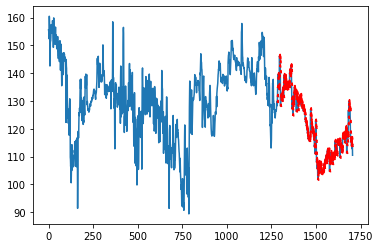

In [16]:

# prepare data
#scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
#model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)